# Unit 15: 深度神經網路(DNN)與多層感知機(MLP)概述
## 實作演練

本notebook將示範完整的DNN建模流程:

0. 環境設定
1. 導入必要套件
2. 數據準備與前處理
3. 模型DNN建立
4. 模型編
5. 設定Callbacks
6. 模型訓練
7. 訓練過程視覺化
8. 模型評估
9. 預測結果視覺化
10. 模型保存與載入

---

## 0. 環境設定
- 本教學課程使用Google Colab環境, 並使用TensorFlow/Keras模組建立DNN(MLP)模型.
- 學生也可以使用自己的電腦, 但需配備NVIDIA GPU, 建議規格為RTX 3060或更高版本. 
- 學生電腦環境安裝請參閱Part_0/Unit00_Local_Environment_Setup.ipynb.

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P4_Unit15_Results'
SOURCE_DATA_DIR = ''

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_4'/ 'Unit15'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\data
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Results
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Results\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Results\figs

TensorFlow Version: 2.10.1
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


---
## 1. 導入必要套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import joblib, pickle
import warnings
warnings.filterwarnings('ignore')

# sklearn套件
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

print(f"TensorFlow版本: {tf.__version__}")
print(f"Keras版本: {keras.__version__}")

# 設定隨機種子以確保結果可重現
np.random.seed(42)
tf.random.set_seed(42)

# 設定matplotlib中文顯示
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial'] # Colab不支援
plt.rcParams['axes.unicode_minus'] = False

TensorFlow版本: 2.10.1
Keras版本: 2.10.0


## 2. 數據準備

### 2.1 生成模擬數據

我們將生成一個回歸問題的模擬數據集,其中目標變數是輸入特徵的非線性組合。

In [3]:
# 生成模擬數據
def generate_data(n_samples=2000, n_features=10, noise_level=0.1):
    """
    生成回歸問題的模擬數據
    
    參數:
        n_samples: 樣本數量
        n_features: 特徵數量
        noise_level: 噪音水平
    
    返回:
        X: 特徵矩陣
        y: 目標變數
    """
    X = np.random.randn(n_samples, n_features)
    
    # 創建複雜的非線性關係
    y = (2 * X[:, 0]**2 +          # 二次項
         3 * X[:, 1] * X[:, 2] +   # 交互作用項
         np.sin(X[:, 3]) * 5 +     # 非線性項
         -1.5 * X[:, 4] +          # 線性項
         np.exp(X[:, 5] * 0.5) +   # 指數項
         np.random.randn(n_samples) * noise_level)  # 噪音
    
    return X, y

# 生成數據
X, y = generate_data(n_samples=2000, n_features=10, noise_level=0.5)

print(f"特徵矩陣形狀: {X.shape}")
print(f"目標變數形狀: {y.shape}")
print(f"\n目標變數統計:")
print(f"  平均值: {y.mean():.4f}")
print(f"  標準差: {y.std():.4f}")
print(f"  最小值: {y.min():.4f}")
print(f"  最大值: {y.max():.4f}")

特徵矩陣形狀: (2000, 10)
目標變數形狀: (2000,)

目標變數統計:
  平均值: 3.2006
  標準差: 5.5159
  最小值: -18.7227
  最大值: 31.2979


### 2.2 數據視覺化

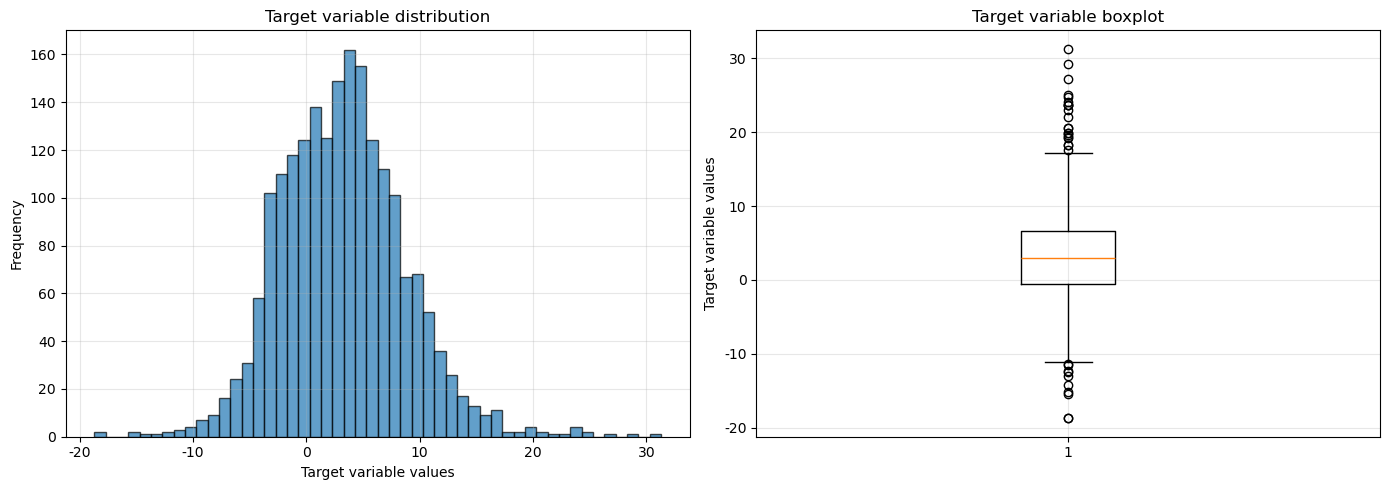

In [4]:
# 視覺化目標變數分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 直方圖
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Target variable values')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Target variable distribution')
axes[0].grid(True, alpha=0.3)

# 箱型圖
axes[1].boxplot(y, vert=True)
axes[1].set_ylabel('Target variable values')
axes[1].set_title('Target variable boxplot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'target_variable_distribution.png')
plt.show()

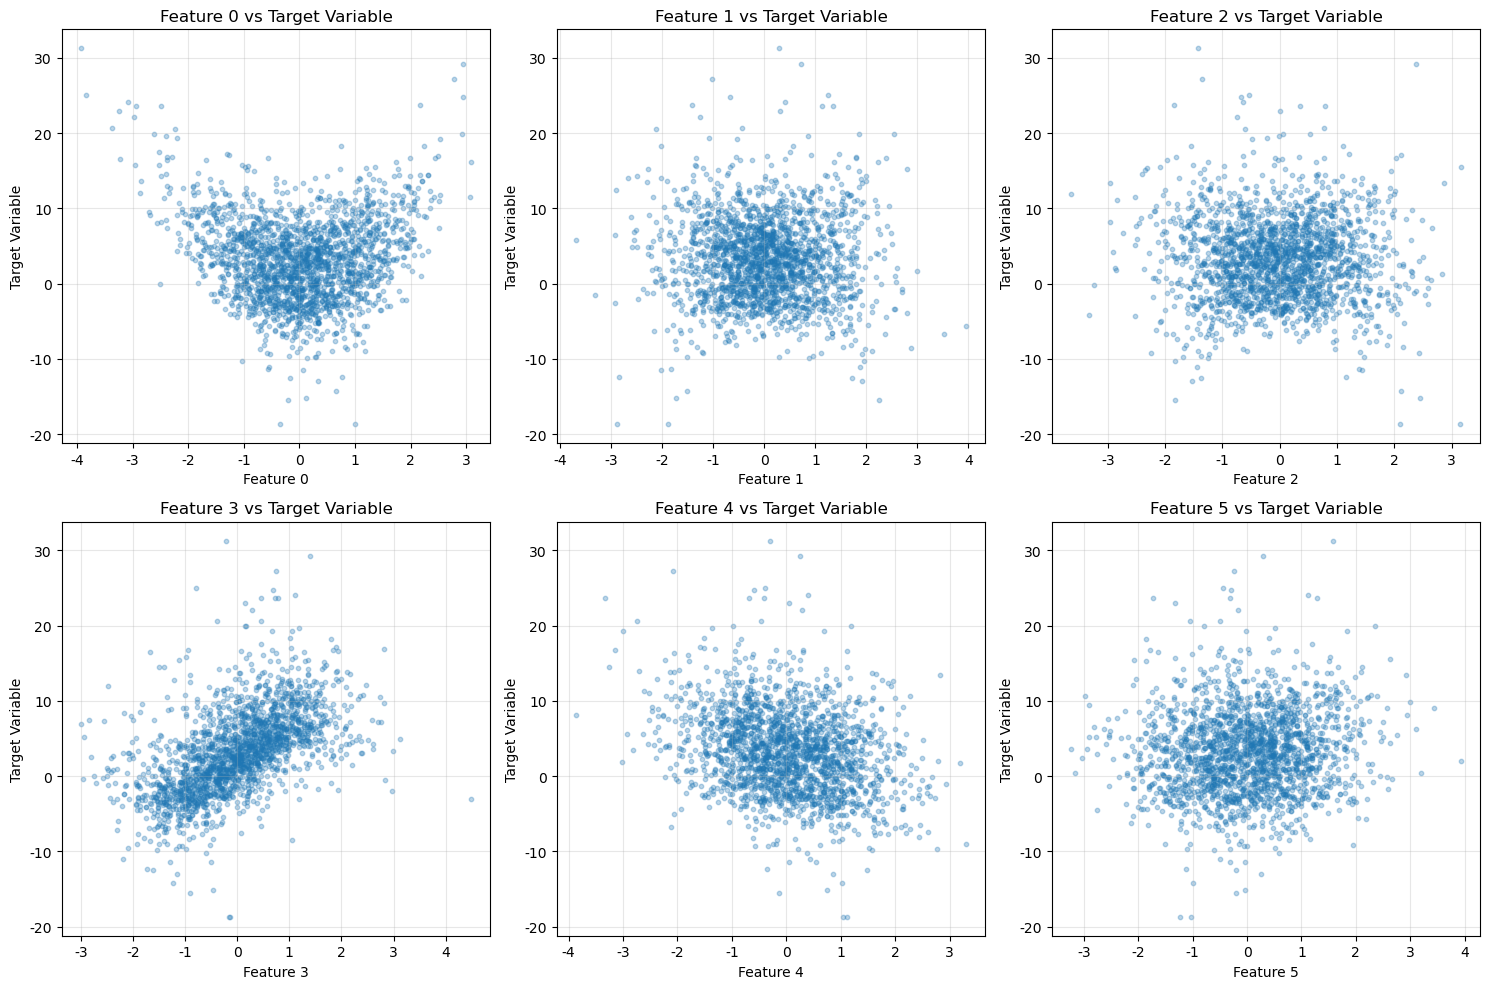

In [5]:
# 視覺化部分特徵與目標變數的關係
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i in range(6):
    axes[i].scatter(X[:, i], y, alpha=0.3, s=10)
    axes[i].set_xlabel(f'Feature {i}')
    axes[i].set_ylabel('Target Variable')
    axes[i].set_title(f'Feature {i} vs Target Variable')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_target_relationship.png')
plt.show()

### 2.3 數據分割

將數據分為訓練集(70%)、驗證集(15%)、測試集(15%)

In [6]:
# 第一次分割: 分離出訓練集和臨時數據集
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 第二次分割: 將臨時數據集分為驗證集和測試集
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print("數據集大小:")
print(f"  訓練集: {X_train.shape[0]} 樣本 ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  驗證集: {X_val.shape[0]} 樣本 ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  測試集: {X_test.shape[0]} 樣本 ({X_test.shape[0]/len(X)*100:.1f}%)")

數據集大小:
  訓練集: 1400 樣本 (70.0%)
  驗證集: 300 樣本 (15.0%)
  測試集: 300 樣本 (15.0%)


### 2.4 特徵縮放

使用StandardScaler進行特徵標準化,這對神經網路的訓練非常重要。

In [7]:
# 初始化scalers
X_scaler = StandardScaler()
y_scaler = StandardScaler()  # 新增: Y的scaler

# 對X進行標準化
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)

# 對Y進行標準化 (新增)
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()
print("特徵與目標變數縮放完成")
print(f"\nX訓練集縮放後統計:")
print(f"  平均值: {X_train_scaled.mean(axis=0)[:3]}...")
print(f"  標準差: {X_train_scaled.std(axis=0)[:3]}...")
print(f"\nY訓練集縮放後統計:")
print(f"  平均值: {y_train_scaled.mean():.4f}")
print(f"  標準差: {y_train_scaled.std():.4f}")
print(f"\n⚠️ 重要: 已保存y_scaler,評估時需要反標準化!")

特徵與目標變數縮放完成

X訓練集縮放後統計:
  平均值: [-6.52652535e-17 -3.45755171e-17 -1.53721282e-17]...
  標準差: [1. 1. 1.]...

Y訓練集縮放後統計:
  平均值: 0.0000
  標準差: 1.0000

⚠️ 重要: 已保存y_scaler,評估時需要反標準化!


---
## 3. 建立DNN模型

### 3.1 使用Sequential API建立模型

In [8]:
# 建立Sequential模型
model = Sequential([
    # 第一隱藏層: 64個神經元
    Dense(64, activation='relu', input_shape=(10,), name='hidden_layer_1'),
    #BatchNormalization(name='batch_norm_1'),
    Dropout(0.3, name='dropout_1'),
    
    # 第二隱藏層: 32個神經元
    Dense(32, activation='relu', name='hidden_layer_2'),
    #BatchNormalization(name='batch_norm_2'),
    Dropout(0.3, name='dropout_2'),
    
    # 第三隱藏層: 16個神經元
    Dense(16, activation='relu', name='hidden_layer_3'),
    Dropout(0.2, name='dropout_3'),
    
    # 輸出層: 1個神經元 (回歸問題)
    Dense(1, name='output_layer')
], name='DNN_Regression_Model')

print("模型建立完成")

模型建立完成


### 3.2 查看模型架構

In [9]:
# 顯示模型摘要
model.summary()

Model: "DNN_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                704       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 hidden_layer_2 (Dense)      (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 hidden_layer_3 (Dense)      (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 output_layer (Dense)        (None, 1)        

### 3.3 使用plot_model視覺化模型結構
使用`plot_model()`將模型架構繪製成圖片,更直觀地理解網路結構。

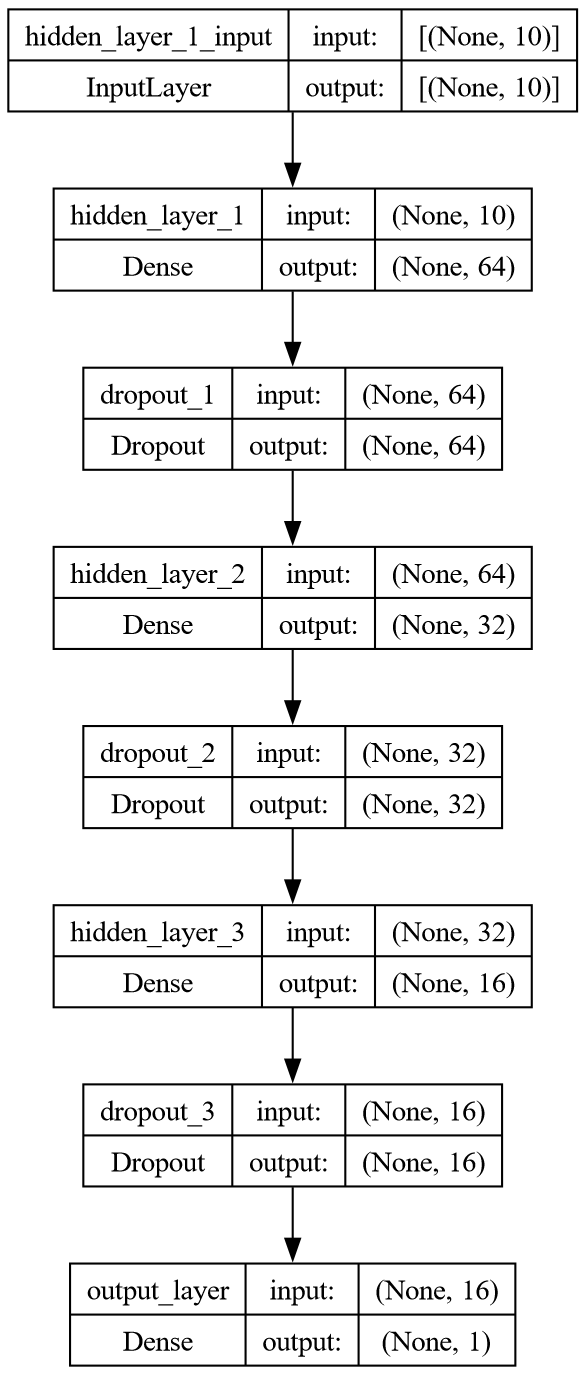

✅ 模型架構圖已保存


In [10]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
model_fig = FIG_DIR / 'model_architecture.png'
try:
    plot_model(
        model,
        to_file=model_fig,
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        dpi=150
    )
    display(Image(model_fig))
    print("✅ 模型架構圖已保存")
except:
    print("⚠️ 需要安裝 graphviz")

**提示**: 如遇graphviz錯誤:
`pip install pydot graphviz`
Windows需額外安裝: https://graphviz.org/download/

---
## 4. 編譯模型

指定優化器、損失函數和評估指標

In [11]:
# 編譯模型
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam優化器,學習率0.001
    loss='mse',                           # 均方誤差損失函數
    metrics=['mae', 'mse']                # 評估指標: MAE和MSE
)

print("模型編譯完成")
print(f"\n優化器: Adam (learning_rate=0.001)")
print(f"損失函數: MSE (Mean Squared Error)")
print(f"評估指標: MAE, MSE")

模型編譯完成

優化器: Adam (learning_rate=0.001)
損失函數: MSE (Mean Squared Error)
評估指標: MAE, MSE


---
## 5. 設定Callbacks

使用callbacks來優化訓練過程

In [12]:
# 創建TensorBoard日誌目錄
log_dir = OUTPUT_DIR / Path("logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
log_dir.mkdir(parents=True, exist_ok=True)

# 定義callbacks
callbacks = [
    # Early Stopping: 當驗證損失不再改善時提前停止訓練
    EarlyStopping(
        monitor='val_loss',           # 監控驗證損失
        patience=30,                  # 容忍30輪沒有改善
        restore_best_weights=True,    # 恢復最佳權重
        verbose=1,
        mode='min'
    ),
    
    # Model Checkpoint: 保存驗證損失最佳的模型
    ModelCheckpoint(
        filepath=MODEL_DIR / 'best_model_temp.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    
    # Reduce Learning Rate: 當訓練停滯時降低學習率
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,                   # 學習率減半
        patience=15,                  # 容忍15輪沒有改善
        min_lr=1e-7,                  # 最小學習率
        verbose=1
    ),

    # TensorBoard: 訓練過程視覺化
    TensorBoard(
        log_dir=log_dir,            # 指定日誌目錄
        histogram_freq=1,           # 每1輪更新一次
        update_freq='epoch'         # 每輪更新
    )
]

print("Callbacks設定完成:")
print("1. EarlyStopping - 監控val_loss, patience=30")
print("2. ModelCheckpoint - 保存最佳模型")
print("3. ReduceLROnPlateau - 動態調整學習率")
print(f"4. TensorBoard - 訓練過程視覺化, 日誌目錄: {log_dir}")

Callbacks設定完成:
1. EarlyStopping - 監控val_loss, patience=30
2. ModelCheckpoint - 保存最佳模型
3. ReduceLROnPlateau - 動態調整學習率
4. TensorBoard - 訓練過程視覺化, 日誌目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Results\logs\fit\20260113-093252


---
## 6. 訓練模型

In [13]:
# 訓練模型
print("開始訓練模型...\n")

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=300,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\n訓練完成!")

開始訓練模型...

Epoch 1/300
30/44 [===================>..........] - ETA: 0s - loss: 1.2388 - mae: 0.8434 - mse: 1.2388 
Epoch 1: val_loss improved from inf to 0.85683, saving model to d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Results\models\best_model_temp.keras
44/44 [==============================] - 2s 13ms/step - loss: 1.1182 - mae: 0.7998 - mse: 1.1182 - val_loss: 0.8568 - val_mae: 0.6801 - val_mse: 0.8568 - lr: 0.0010
Epoch 2/300
41/44 [==========================>...] - ETA: 0s - loss: 0.8333 - mae: 0.6996 - mse: 0.8333
Epoch 2: val_loss improved from 0.85683 to 0.73358, saving model to d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Results\models\best_model_temp.keras
44/44 [==============================] - 0s 7ms/step - loss: 0.8437 - mae: 0.7002 - mse: 0.8437 - val_loss: 0.7336 - val_mae: 0.6116 - val_mse: 0.7336 - lr: 0.0010
Epoch 3/300
31/44 [====================>.........] - ETA: 0s - loss: 0.7993 - mae: 0.6583 - mse: 0.7993
Epoch 3: val_loss improved from

---
## 7. 訓練過程視覺化

### 7.1 損失曲線與指標曲線

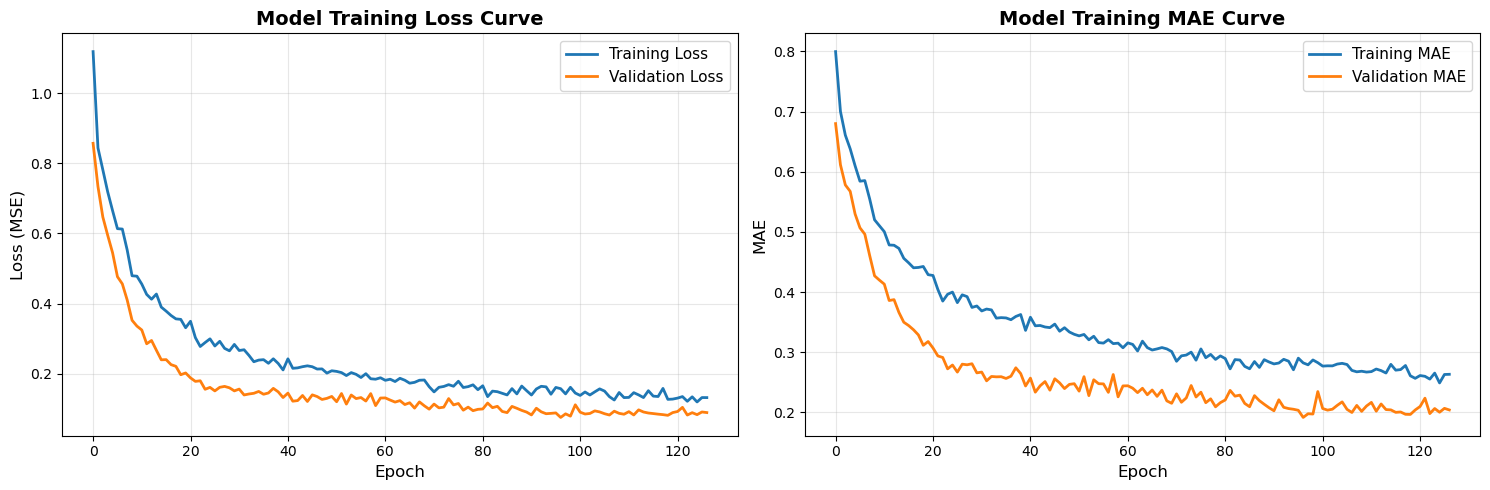

In [14]:
# 繪製訓練歷史
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 損失曲線
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Model Training Loss Curve', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# MAE曲線
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Model Training MAE Curve', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'training_history.png')
plt.show()

### 7.2 查看訓練摘要

In [15]:
# 訓練摘要
print(f"訓練輪數: {len(history.history['loss'])}")
print(f"\n最終訓練損失: {history.history['loss'][-1]:.4f}")
print(f"最終驗證損失: {history.history['val_loss'][-1]:.4f}")
print(f"\n最佳驗證損失: {min(history.history['val_loss']):.4f}")
print(f"出現在第 {np.argmin(history.history['val_loss'])+1} 輪")

訓練輪數: 127

最終訓練損失: 0.1319
最終驗證損失: 0.0892

最佳驗證損失: 0.0754
出現在第 97 輪


### 7.3 使用TensorBoard查看訓練過程
TensorBoard提供專業的訓練視覺化工具。

In [16]:
# 在Jupyter中啟動TensorBoard
# %load_ext tensorboard
# %tensorboard --logdir log_dir.parent

# 或在終端執行: tensorboard --logdir=logs/fit
# 然後使用瀏覽器開啟 http://localhost:6006/

---
## 8. 模型評估

### 8.1 在測試集上評估

In [17]:
# 使用model.evaluate()評估
test_results = model.evaluate(X_test_scaled, y_test_scaled, verbose=1)

print("測試集評估結果:")
print(f"  Loss (MSE): {test_results[0]:.4f}")
print(f"  MAE: {test_results[1]:.4f}")
print(f"  MSE: {test_results[2]:.4f}")

10/10 [==============================] - 0s 2ms/step - loss: 0.1146 - mae: 0.2342 - mse: 0.1146
測試集評估結果:
  Loss (MSE): 0.1146
  MAE: 0.2342
  MSE: 0.1146


### 8.2 詳細指標計算

In [18]:
# 在各數據集上進行預測
y_train_pred_scaled = model.predict(X_train_scaled, verbose=0).flatten()
y_val_pred_scaled = model.predict(X_val_scaled, verbose=0).flatten()
y_test_pred_scaled = model.predict(X_test_scaled, verbose=0).flatten()

# ⚠️ 重要: 反標準化至原始尺度
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
print("✅ 預測完成並已反標準化")

# 使用原始尺度計算指標
def calculate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} (原始尺度):")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

# 計算各數據集的指標
print("="*50)
print("詳細評估指標")
print("="*50)

train_metrics = calculate_metrics(y_train, y_train_pred, "訓練集")
val_metrics = calculate_metrics(y_val, y_val_pred, "驗證集")
test_metrics = calculate_metrics(y_test, y_test_pred, "測試集")

✅ 預測完成並已反標準化
詳細評估指標

訓練集 (原始尺度):
  MAE:  0.9718
  MSE:  1.7422
  RMSE: 1.3199
  R²:   0.9417

驗證集 (原始尺度):
  MAE:  1.0472
  MSE:  2.2505
  RMSE: 1.5002
  R²:   0.9306

測試集 (原始尺度):
  MAE:  1.2797
  MSE:  3.4215
  RMSE: 1.8497
  R²:   0.8890


### 8.3 指標比較視覺化

In [19]:
# 整理指標數據
metrics_df = pd.DataFrame({
    '訓練集': [train_metrics['MAE'], train_metrics['RMSE'], train_metrics['R2']],
    '驗證集': [val_metrics['MAE'], val_metrics['RMSE'], val_metrics['R2']],
    '測試集': [test_metrics['MAE'], test_metrics['RMSE'], test_metrics['R2']]
}, index=['MAE', 'RMSE', 'R²'])

print("\n指標比較表:")
print(metrics_df)


指標比較表:
           訓練集       驗證集       測試集
MAE   0.971816  1.047240  1.279746
RMSE  1.319940  1.500157  1.849736
R²    0.941653  0.930578  0.889023


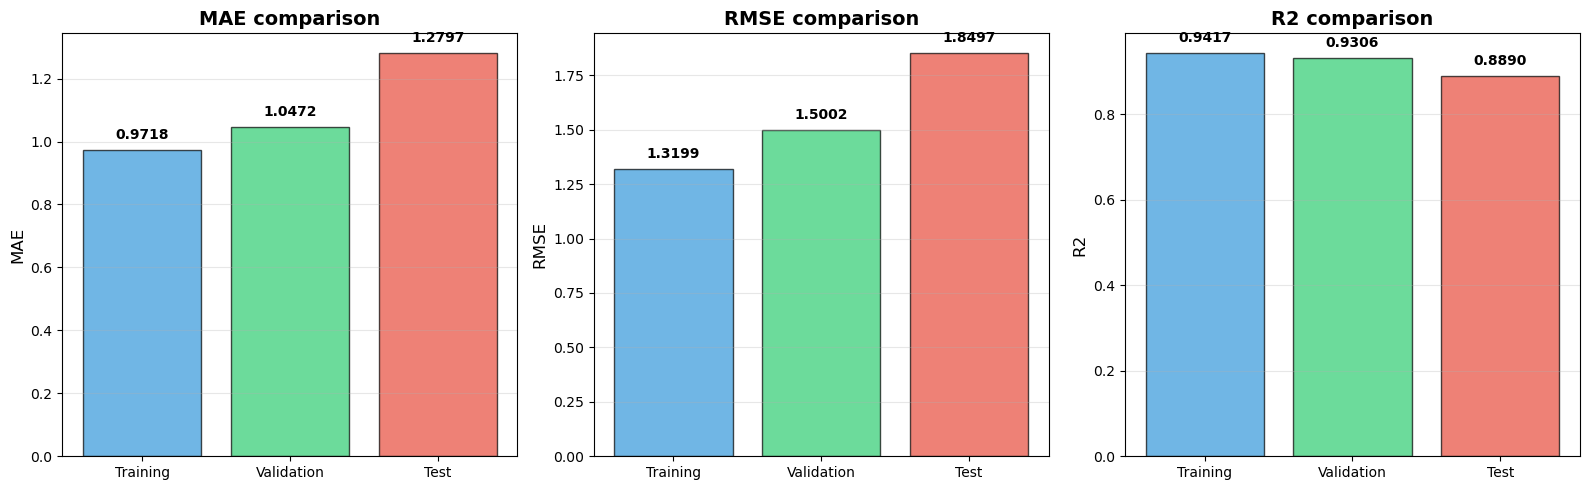

In [20]:
# 繪製指標比較圖
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

datasets = ['Training', 'Validation', 'Test']
metrics_list = [train_metrics, val_metrics, test_metrics]
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, metric_name in enumerate(['MAE', 'RMSE', 'R2']):
    values = [m[metric_name] for m in metrics_list]
    axes[idx].bar(datasets, values, color=colors, alpha=0.7, edgecolor='black')
    axes[idx].set_ylabel(metric_name, fontsize=12)
    axes[idx].set_title(f'{metric_name} comparison', fontsize=14, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # 在柱狀圖上標註數值
    for i, v in enumerate(values):
        axes[idx].text(i, v + max(values)*0.02, f'{v:.4f}', 
                       ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'model_metrics_comparison.png')
plt.show()

---
## 9. 預測結果視覺化

### 9.1 實際值 vs 預測值散點圖

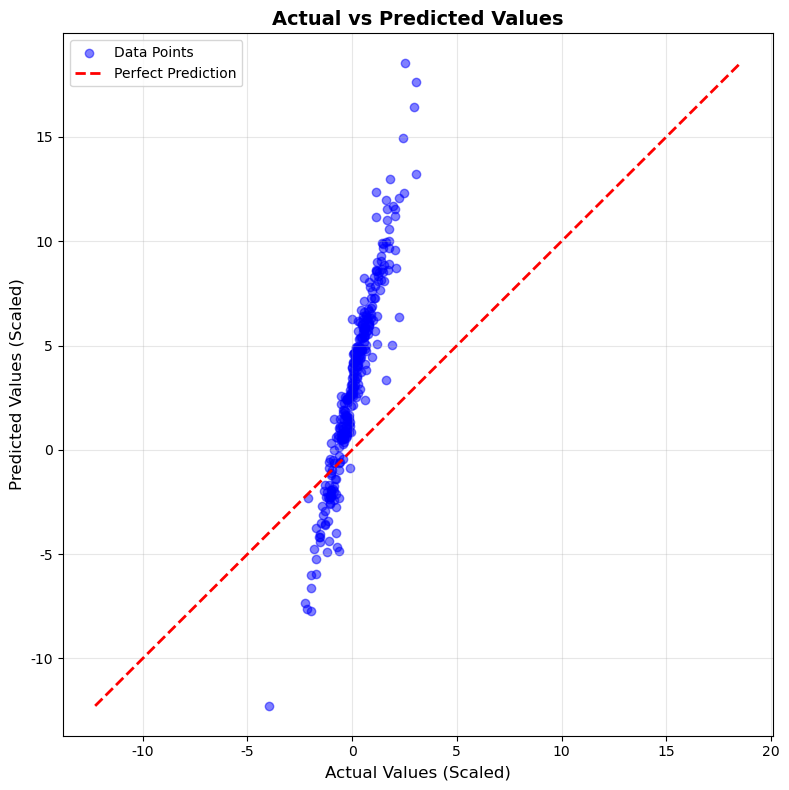

In [21]:
# 9.1 實際值 vs 預測值散點圖
plt.figure(figsize=(8, 8))
# Use flattened arrays for plotting
y_true = y_test_scaled.flatten() if hasattr(y_test_scaled, 'flatten') else y_test_scaled
y_pred = y_test_pred.flatten() if hasattr(y_test_pred, 'flatten') else y_test_pred

plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Data Points')
# Perfect prediction line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Values (Scaled)', fontsize=12)
plt.ylabel('Predicted Values (Scaled)', fontsize=12)
plt.title('Actual vs Predicted Values', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
if 'FIG_DIR' in locals():
    plt.savefig(FIG_DIR / 'actual_vs_predicted.png')
plt.show()

### 9.2 殘差分析

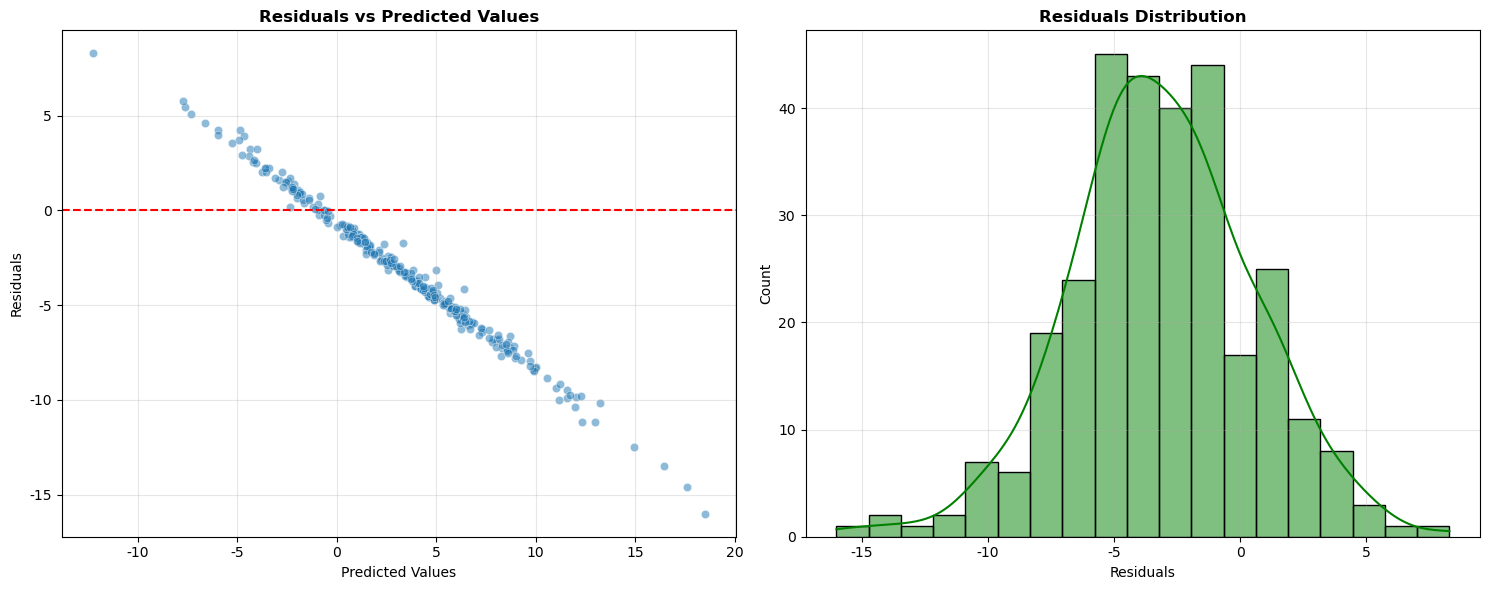

In [22]:
# 9.2 殘差分析
residuals = y_true - y_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Residuals vs Predicted
sns.scatterplot(x=y_pred, y=residuals, ax=axes[0], alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predicted Values', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residuals Distribution
sns.histplot(residuals, kde=True, ax=axes[1], color='green')
axes[1].set_xlabel('Residuals')
axes[1].set_title('Residuals Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
if 'FIG_DIR' in locals():
    plt.savefig(FIG_DIR / 'residuals_analysis.png')
plt.show()

---
## 10. 模型保存與載入

### 10.1 保存完整模型

In [23]:
# 10. 模型保存
if 'model' in locals():
    import datetime
    import pickle
    
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save Model
    if 'MODEL_DIR' in locals():
        model_path = MODEL_DIR / f'dnn_model_{current_time}.h5'
        model.save(model_path)
        print(f"Model saved to: {model_path}")

        # Save History
        history_path = MODEL_DIR / f'training_history_{current_time}.pkl'
        with open(history_path, 'wb') as f:
            pickle.dump(history.history, f)
        print(f"History saved to: {history_path}")
    else:
        print("MODEL_DIR not defined, skipping save.")

Model saved to: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Results\models\dnn_model_20260113_093339.h5
History saved to: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Results\models\training_history_20260113_093339.pkl


### 10.2 載入模型

In [25]:
# 載入Keras模型
loaded_model = load_model(model_path)

print(f"模型已從 {model_path} 載入")
print("\n載入的模型架構:")
loaded_model.summary()

模型已從 d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Results\models\dnn_model_20260113_093339.h5 載入

載入的模型架構:
Model: "DNN_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                704       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 hidden_layer_2 (Dense)      (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 hidden_layer_3 (Dense)      (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0     

### 10.3 驗證載入的模型

In [26]:
# 使用載入的模型進行預測
loaded_predictions_scaled = loaded_model.predict(X_test_scaled, verbose=0).flatten()

# 反標準化預測值
loaded_predictions = y_scaler.inverse_transform(loaded_predictions_scaled.reshape(-1, 1)).flatten()

# 驗證預測結果是否一致
predictions_match = np.allclose(y_test_pred, loaded_predictions)

print(f"載入模型的預測與原模型一致: {predictions_match}")

# 計算載入模型的評估指標
loaded_mae = mean_absolute_error(y_test, loaded_predictions)
loaded_rmse = np.sqrt(mean_squared_error(y_test, loaded_predictions))
loaded_r2 = r2_score(y_test, loaded_predictions)

print(f"\n載入模型在測試集上的表現:")
print(f"  MAE:  {loaded_mae:.4f}")
print(f"  RMSE: {loaded_rmse:.4f}")
print(f"  R²:   {loaded_r2:.4f}")

載入模型的預測與原模型一致: True

載入模型在測試集上的表現:
  MAE:  1.2797
  RMSE: 1.8497
  R²:   0.8890


### 10.4 單一樣本預測示例

In [27]:
# 選擇一個測試樣本
sample_idx = 0
single_sample = X_test_scaled[sample_idx:sample_idx+1]  # 保持2D形狀
actual_value = y_test[sample_idx]

# 使用載入的模型進行預測
predicted_value_scaled = loaded_model.predict(single_sample, verbose=0)[0][0]

# 反標準化預測值
predicted_value = y_scaler.inverse_transform([[predicted_value_scaled]])[0][0]

print(f"單一樣本預測示例:")
print(f"  實際值: {actual_value:.4f}")
print(f"  預測值: {predicted_value:.4f}")
print(f"  誤差: {abs(actual_value - predicted_value):.4f}")
print(f"  相對誤差: {abs(actual_value - predicted_value) / abs(actual_value) * 100:.2f}%")

單一樣本預測示例:
  實際值: 3.2976
  預測值: 2.5783
  誤差: 0.7192
  相對誤差: 21.81%


### 10.5 History保存與載入

In [28]:
# 10. 模型保存
if 'model' in locals():
    import datetime
    import pickle
    
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save Model
    if 'MODEL_DIR' in locals():
        model_path = MODEL_DIR / f'dnn_model_{current_time}.h5'
        model.save(model_path)
        print(f"Model saved to: {model_path}")

        # Save History
        history_path = MODEL_DIR / f'training_history_{current_time}.pkl'
        with open(history_path, 'wb') as f:
            pickle.dump(history.history, f)
        print(f"History saved to: {history_path}")
    else:
        print("MODEL_DIR not defined, skipping save.")

Model saved to: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Results\models\dnn_model_20260113_093451.h5
History saved to: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Results\models\training_history_20260113_093451.pkl


10.6 模型與History完整保存方案

In [29]:
# 10. 模型保存
if 'model' in locals():
    import datetime
    import pickle
    
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save Model
    if 'MODEL_DIR' in locals():
        model_path = MODEL_DIR / f'dnn_model_{current_time}.h5'
        model.save(model_path)
        print(f"Model saved to: {model_path}")

        # Save History
        history_path = MODEL_DIR / f'training_history_{current_time}.pkl'
        with open(history_path, 'wb') as f:
            pickle.dump(history.history, f)
        print(f"History saved to: {history_path}")
    else:
        print("MODEL_DIR not defined, skipping save.")

Model saved to: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Results\models\dnn_model_20260113_093506.h5
History saved to: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Results\models\training_history_20260113_093506.pkl


---
## 11. 總結

本notebook完整示範了使用TensorFlow/Keras建立DNN回歸模型的流程:

### ✅ 已完成步驟:

1. **數據準備**
   - 生成模擬數據 (非線性回歸問題)
   - 數據視覺化與探索
   - 數據分割 (訓練/驗證/測試)
   - 特徵標準化

2. **模型建立**
   - 使用Sequential API建立深度神經網路
   - 包含Dense、BatchNormalization、Dropout層
   - 查看模型架構與參數數量

3. **模型編譯**
   - 配置Adam優化器
   - 設定MSE損失函數
   - 定義評估指標 (MAE, MSE)

4. **模型訓練**
   - 設定callbacks (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
   - 訓練模型並記錄歷史
   - 視覺化訓練過程

5. **模型評估**
   - 在測試集上評估模型
   - 計算詳細指標 (MAE, MSE, RMSE, R²)
   - 比較訓練/驗證/測試集表現

6. **預測與分析**
   - 進行預測
   - 實際值 vs 預測值視覺化
   - 殘差分析

7. **模型持久化**
   - 保存完整模型
   - 載入模型
   - 驗證載入模型的正確性

### 📚 關鍵技術要點:

- **特徵縮放**: 使用StandardScaler進行標準化,提升訓練效果
- **正則化**: 使用Dropout和BatchNormalization防止過擬合
- **Early Stopping**: 自動停止訓練,避免過度訓練
- **學習率調整**: ReduceLROnPlateau動態調整學習率
- **模型檢查點**: 自動保存驗證集上表現最佳的模型

### 🎯 下一步學習:

請參考以下附錄案例,了解DNN在實際化工問題中的應用:
- **Unit15_Appendix_FuelGasEmission**: 燃料氣體排放預測
- **Unit15_Appendix_distillation**: 蒸餾塔操作控制
- **Unit15_Appendix_RedWine**: 紅酒品質預測
- **Unit15_Appendix_Mining**: 礦業浮選矽石濃度預測

---

**課程編號**: CHE-AI-114  
**授課教師**: 莊曜禎 助理教授  
**逢甲大學化學工程學系**